In [49]:
import tensorflow as tf
from tensorflow.keras import layers, models, datasets
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import os 
import pickle
from typing import Tuple, Optional
from transformers import pipeline 
import tqdm
import torch 
import warnings
import pandas as pd 
import logging
import mlflow
import mlflow.tensorflow
import tf2onnx
import onnx
import onnxruntime as ort
import numpy as np

from sklearn.base import BaseEstimator , TransformerMixin 

# Setup

In [12]:
warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)
SEED = 42
np.random.seed(SEED)

# Custom transformer for outlier clipping

In [13]:
class OutlierClipper(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.lower_bounds = {}
        self.upper_bounds = {}
    
    def fit(self, X, y=None):
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X, columns=self.columns)
        for col in self.columns:
            Q1 = X[col].quantile(0.25)
            Q3 = X[col].quantile(0.75)
            IQR = Q3 - Q1
            self.lower_bounds[col] = Q1 - 1.5 * IQR
            self.upper_bounds[col] = Q3 + 1.5 * IQR
        return self
    
    def transform(self, X, y=None):
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X, columns=self.columns)
        X_copy = X.copy()
        for col in self.columns:
            X_copy[col] = X_copy[col].clip(lower=self.lower_bounds[col], upper=self.upper_bounds[col])
        return X_copy
    
    def get_feature_names_out(self, input_features=None):
        return np.array(self.columns)

In [15]:
(x_train, y_train),(x_test, y_test) = datasets.mnist.load_data() 

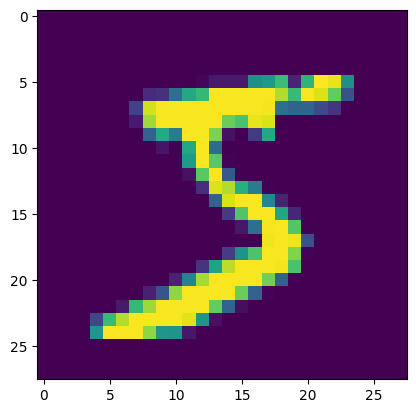

In [16]:
plt.imshow(x_train[0])

In [17]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [18]:
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))

In [19]:
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

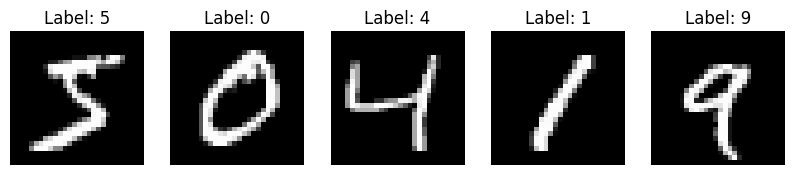

In [20]:
plt.figure(figsize=(10,5))
for i in range(5):
    plt.subplot(1, 5 , i+1)
    plt.imshow(x_train[i].reshape(28,28), cmap='gray')
    plt.title(f'Label: {np.argmax(y_train[i])}')
    plt.axis("OFF")
    
plt.show()

In [21]:
model = models.Sequential([
    # layer One
	layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    
    #layer two
    layers.Conv2D(62, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    
    layers.Flatten(),
    
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
    
    
    
])

2025-07-12 19:52:05.274776: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-12 19:52:05.675086: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 62)        17918     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 62)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1550)              0         
                                                                 
 dense (Dense)               (None, 128)               1

In [23]:
model.compile(
	optimizer='adam',
	loss='categorical_crossentropy',
	metrics=['accuracy']
)

In [24]:
history = model.fit(x_train, y_train, epochs=5, batch_size=64, validation_split=0.2)

2025-07-12 19:52:39.092456: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150528000 exceeds 10% of free system memory.


Epoch 1/5
749/750 [============================>.] - ETA: 0s - loss: 0.1823 - accuracy: 0.9423

2025-07-12 19:53:06.513274: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 37632000 exceeds 10% of free system memory.


750/750 [==============================] - 28s 36ms/step - loss: 0.1822 - accuracy: 0.9424 - val_loss: 0.0629 - val_accuracy: 0.9813
Epoch 2/5
750/750 [==============================] - 27s 36ms/step - loss: 0.0559 - accuracy: 0.9823 - val_loss: 0.0528 - val_accuracy: 0.9850
Epoch 3/5
750/750 [==============================] - 27s 35ms/step - loss: 0.0376 - accuracy: 0.9886 - val_loss: 0.0459 - val_accuracy: 0.9866
Epoch 4/5
750/750 [==============================] - 27s 36ms/step - loss: 0.0277 - accuracy: 0.9908 - val_loss: 0.0428 - val_accuracy: 0.9879
Epoch 5/5
750/750 [==============================] - 27s 36ms/step - loss: 0.0202 - accuracy: 0.9934 - val_loss: 0.0423 - val_accuracy: 0.9879


In [25]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)  

  9/313 [..............................] - ETA: 2s - loss: 0.0272 - accuracy: 0.9931

2025-07-12 19:55:04.739996: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31360000 exceeds 10% of free system memory.


313/313 [==============================] - 2s 6ms/step - loss: 0.0339 - accuracy: 0.9893


In [26]:
print(f'This is about the accuracy in this data set: {test_accuracy:.4f}')

This is about the accuracy in this data set: 0.9893


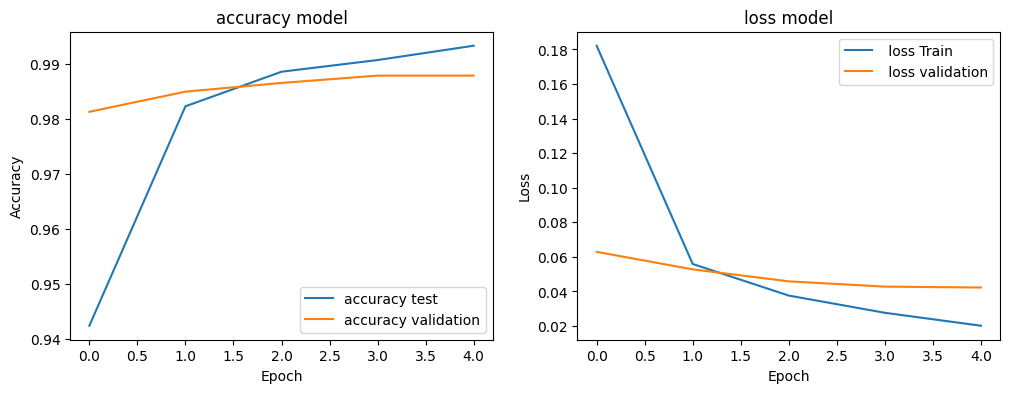

In [27]:
plt.figure(figsize=(12, 4))

# accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy test')
plt.plot(history.history['val_accuracy'], label='accuracy validation')
plt.title('accuracy model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label=' loss Train')
plt.plot(history.history['val_loss'], label=' loss validation')
plt.title('loss model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

1/1 [==============================] - 0s 101ms/step


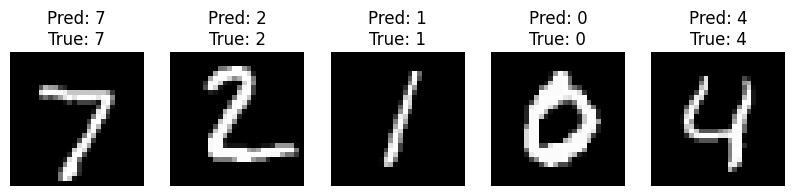

In [28]:
predictions = model.predict(x_test[:5])

plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title(f"Pred: {np.argmax(predictions[i])}\nTrue: {np.argmax(y_test[i])}")
    plt.axis('off')
plt.show()

In [46]:
model.save("saved_model_tf", save_format="tf")


2025-07-12 20:15:00,891 - WARNING - Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _update_step_xla while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: saved_model_tf/assets


2025-07-12 20:15:01,170 - INFO - Assets written to: saved_model_tf/assets


In [ ]:

session = ort.InferenceSession("eeg_cnn_model.onnx")

input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

input_data = np.random.rand(1, 28, 28, 1).astype(np.float32)
output = session.run([output_name], {input_name: input_data})
print("Predicted:", output)


Predicted: [array([[0.09925293, 0.11236034, 0.08616048, 0.09941671, 0.09701873,
        0.08436703, 0.10121134, 0.09477645, 0.11025731, 0.11517859]],
      dtype=float32)]


# CIFAR-10

In [29]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dic = pickle.load(fo, encoding='bytes')
        return dic
    
    
file_data = '../../data/cifar-10-batches-py'



x_train = []
y_train = []
for i in range(1, 6):
    
    batch = unpickle(os.path.join(file_data, f'data_batch_{i}'))
    x_train.append(batch[b'data'])
    y_train.append(batch[b'labels'])
x_train = np.concatenate(x_train)
y_train = np.concatenate(y_train)

In [17]:
test_bach = unpickle(os.path.join(file_data, 'test_batch'))


In [18]:
x_test = test_bach[b'data']
y_test = np.array(test_bach[b'labels'])

In [19]:
y_test

array([3, 8, 8, ..., 5, 1, 7])

In [20]:
x_train = x_train.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
x_test = x_test.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

In [21]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [22]:
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

In [23]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [24]:
class_names = ['airplane', 'car', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']



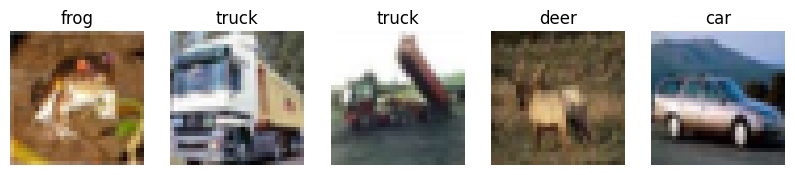

In [25]:
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(x_train[i])
    plt.title(class_names[np.argmax(y_train[i])])
    plt.axis('off')
    
plt.show()
    

In [26]:
class Conv2D:
    def __init__(self, filters: int, kernel_size: Tuple[int, int], activation: str = "relu", padding: str = 'same'):
        self.filters = filters
        self.kernel_size = kernel_size
        self.activation = activation
        self.padding = padding
        self.weights = None
        self.bias = None
        
        
    def initialize_weights(self, input_shape: Tuple[int, int, int]):	
        fan_in = np.prod(self.kernel_size) * input_shape[2]
        fan_out = np.prod(self.kernel_size) * self.filters
        limit = np.sqrt(6 / (fan_in + fan_out))
        self.weights = np.random.uniform(-limit, limit, (self.kernel_size[0], self.kernel_size[1], input_shape[2], self.filters))
        self.bias = np.zeros((self.filters))
        
        
    def forward(self, x: np.ndarray)-> np.ndarray:
        
        batch_size, height, width, channels = x.shape 
        
        if self.weights is None:
            self.initialize_weights((height, width, channels))
            
            
        if self.padding == 'same':
            pad_h = self.kernel_size[0] // 2
            pad_w = self.kernel_size[1] // 2
            x_padded = np.pad(x, ((0,0), (pad_h, pad_h), (pad_w, pad_w), (0,0)), mode='constant')
        else:
            x_padded = x      
        
        
        out_height = x_padded.shaep[1] - self.kernel_size[0] + 1
        
        out_weight = x_padded.shaep[2] - self.kernel_size[1] + 1
        
        output = np.zeros((batch_size, out_height, out_weight, self.filters))
        
        
        
        for i in range(out_height):
            for j in range(out_weight):
                for f in range(self.filters):
                    region = x_padded[:, i:i+self.kernel_size[0],j:j+self.kernel_size[1], :]
                    output[:, i, j, f] = np.sum(region * self.weights[:, :, :, f], axis=(1, 2, 3)) + self.bias[f]
                    
                    
        if self.activation == 'relu':
            output = np.maximum(0, output)
            
        return output
            
class BatchNormalization:
    
    def __init__(self, epsilon: float = 1e-5, momentum: float = 0.99):
        self.epsilon = epsilon
        self.momentum = momentum
        self.gamma = None
        self.beta = None
        self.running_mean = None
        self.running_var = None
        self.training = True
    
    def forward(self, x: np.ndarray)-> np.ndarray:
        if self.gamma is None:
            shape = x.shape[-1 :]
    
            self.gamma = np.ones(shape)
            self.beta = np.zeros(shape)
    
            self.running_mean = np.zeros(shape)
            self.running_var = np.ones(shape)
            
            
        if self.training:
            
            batch_mean = np.mean(x, axis=(0, 1, 2), keepdims=True)
            batch_var = np.var(x, axis=(0, 1 ,2), keepdims=True)
            
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * batch_mean.squeeze()
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * batch_var.squeeze()
            
            
            # Normalize
            
            x_norm = (x - batch_mean) / np.sqrt(batch_var + self.epsilon)
            
        else:
            x_norm = (x - self.running_mean) / np.sqrt(self.running_var + self.epsilon) 
            
        return self.gamma * x_norm + self.beta
    
    
    
class MaxPooling2D:
    def __init__(self, pool_size: Tuple[int, int] = (2, 2)):
        self.pool_size = pool_size
        
        
    def forward(self, x: np.ndarray) -> np.ndarray:
        batch_size, height, width, channels = x.shape
        
        
        
        out_height = height // self.pool_size[0]
        out_width = width // self.pool_size[1]
        
        
        
        
        output = np.zeros((batch_size, out_height, out_width, channels ))
        
        for i in range(out_height):
            for j in range(out_width):
                h_start = i * self.pool_size[0] 
                h_end = h_start + self.pool_size[0]
                w_start = j * self.pool_size[1]
                w_end = w_start + self.pool_size[1]
                
                pool_region = x[:, h_start:h_end, w_start: w_end, :]
                
                output[:, i, j, :] = np.max(pool_region, axis=(1,2))
                
                
        return output
    
class Dropout:
    def __init__(self, rate: float): 
        self.rate = rate
        self.training = True
        
        
    def forward(self, x: np.ndarray) -> np.ndarray:
        if self.training and self.rate > 0:
            keep_prob = 1 - self.rate
            mask = np.random.binomial(1, keep_prob, size=x.shape) / keep_prob
            return x * mask
        return x
        
				
class Flatten:
    def __init__(self)-> None:
        pass
    
    def forward(self,x: np.ndarray)-> np.ndarray:
        batch_size = x.shape[0]
        return x.reshape(batch_size, -1 )
    
    
    
class Dense:
    def __init__(self, units: int, activation: str = 'linear'):
        self.units = units
        self.activation = activation
        self.weights = None
        self.bias = None
        
    def initialize_weights(self, input_dim: int):
        limit = np.sqrt(6 / (input_dim + self.units))
        self.weights = np.random.uniform(-limit , limit, (input_dim, self.units))
        self.bias = np.zeros((self.units))
    
    def forward(self, x: np.ndarray)-> np.ndarray:
        if self.weights is None:
            self.initialize_weights(x.shape[0])
            
            
        output = np.dot(x, self.weights) + self.bias
        
        
        if self.activation == "relu":
            output = np.maximum(0, output)
        
        elif self.activation == 'softmax':
            exp_scores = np.exp(output - np.max(output, axis=1, keepdims=True))
            output = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)    
            
            
        return output
            

In [27]:

class CNN:
    def __init__(self):
        self.layers = [
            Conv2D(32, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            Conv2D(32, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            Dropout(0.25),
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            Dropout(0.25),
            Flatten(),
            Dense(512, activation='relu'),
            BatchNormalization(),
            Dropout(0.5),
            Dense(10, activation='softmax')
        ]
    
    def forward(self, x: np.ndarray) -> np.ndarray:
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def set_training(self, training: bool):
        for layer in self.layers:
            if hasattr(layer, 'training'):
                layer.training = training
    
    def compute_loss(self, y_true: np.ndarray, y_pred: np.ndarray) -> float:
        """Compute categorical cross-entropy loss"""
        # Clip predictions to prevent log(0)
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))
    
    def compute_accuracy(self, y_true: np.ndarray, y_pred: np.ndarray) -> float:
        """Compute classification accuracy"""
        y_true_labels = np.argmax(y_true, axis=1)
        y_pred_labels = np.argmax(y_pred, axis=1)
        return np.mean(y_true_labels == y_pred_labels)
    
    def train_step(self, x: np.ndarray, y: np.ndarray) -> Tuple[float, float]:
        """Perform one training step (forward pass only for now)"""
        self.set_training(True)
        y_pred = self.forward(x)
        loss = self.compute_loss(y, y_pred)
        accuracy = self.compute_accuracy(y, y_pred)
        return loss, accuracy
    
    def evaluate(self, x: np.ndarray, y: np.ndarray, batch_size: int = 32) -> Tuple[float, float]:
        """Evaluate model on test data"""
        self.set_training(False)
        total_loss = 0.0
        total_accuracy = 0.0
        num_batches = 0
        
        for i in range(0, len(x), batch_size):
            batch_x = x[i:i+batch_size]
            batch_y = y[i:i+batch_size]
            
            y_pred = self.forward(batch_x)
            loss = self.compute_loss(batch_y, y_pred)
            accuracy = self.compute_accuracy(batch_y, y_pred)
            
            total_loss += loss
            total_accuracy += accuracy
            num_batches += 1
        
        return total_loss / num_batches, total_accuracy / num_batches

In [3]:
class Layer:
    def __init__(self):
        self.inp = None
        self.out = None
        
        
    def __call__(self, inp: np.ndarray)-> np.ndarray:
        return self.forward(inp)
    
    
    def forward(self, inp: np.ndarray)-> np.ndarray:
        raise NotImplementedError
    
    
    def backward(self, up_grad: np.ndarray)-> np.ndarray:
        raise NotImplementedError
    
    def step(self, lr: float)-> None:
        pass 

In [ ]:
class Linear(Layer):
    def __init__(self, in_dim: int, out_dim: int):
        super().__init__()
        self.w = 0.1 * np.random.randn(in_dim, out_dim)  